In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np

import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import os
import yaml


* Ref: [Building a Vision Transformer Model From Scratch](https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6)

# Patch Embeddings

In [2]:
# class PatchEmbedding(nn.Module):
#   def __init__(self, d_model, img_size, patch_size, n_channels):
#     super().__init__()

#     self.d_model = d_model # Dimensionality of Model
#     self.img_size = img_size # Image Size
#     self.patch_size = patch_size # Patch Size
#     self.n_channels = n_channels # Number of Channels

#     self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

#   # B: Batch Size
#   # C: Image Channels
#   # H: Image Height
#   # W: Image Width
#   # P_col: Patch Column
#   # P_row: Patch Row
#   def forward(self, x):
#     x = self.linear_project(x) # (B, C, H, W) -> (B, d_model, P_col, P_row)

#     x = x.flatten(2) # (B, d_model, P_col, P_row) -> (B, d_model, P)

#     x = x.transpose(-2, -1) # (B, d_model, P) -> (B, P, d_model)

#     return x

# Class Token and Positional Encoding

In [3]:
# class PositionalEncoding(nn.Module):
#   def __init__(self, d_model, max_seq_length):
#     super().__init__()

#     self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # Classification Token

#     # Creating positional encoding
#     pe = torch.zeros(max_seq_length, d_model)

#     for pos in range(max_seq_length):
#       for i in range(d_model):
#         if i % 2 == 0:
#           pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
#         else:
#           pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

#     self.register_buffer('pe', pe.unsqueeze(0))

#   def forward(self, x):
#     # Expand to have class token for every image in batch
#     tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

#     # Adding class tokens to the beginning of each embedding
#     x = torch.cat((tokens_batch,x), dim=1)

#     # Add positional encoding to embeddings
#     x = x + self.pe

#     return x

# Multi-Head Attention

In [4]:
# class AttentionHead(nn.Module):
#   def __init__(self, d_model, head_size):
#     super().__init__()
#     self.head_size = head_size

#     self.query = nn.Linear(d_model, head_size)
#     self.key = nn.Linear(d_model, head_size)
#     self.value = nn.Linear(d_model, head_size)

#   def forward(self, x):
#     # Obtaining Queries, Keys, and Values
#     Q = self.query(x)
#     K = self.key(x)
#     V = self.value(x)

#     # Dot Product of Queries and Keys
#     attention = Q @ K.transpose(-2,-1)

#     # Scaling
#     attention = attention / (self.head_size ** 0.5)

#     attention = torch.softmax(attention, dim=-1)

#     attention = attention @ V

#     return attention

In [5]:
# class MultiHeadAttention(nn.Module):
#   def __init__(self, d_model, n_heads):
#     super().__init__()
#     self.head_size = d_model // n_heads

#     self.W_o = nn.Linear(d_model, d_model)

#     self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

#   def forward(self, x):
#     # Combine attention heads
#     out = torch.cat([head(x) for head in self.heads], dim=-1)

#     out = self.W_o(out)

#     return out

# Transformer Encoder

In [6]:
# 

In [7]:
# class TransformerEncoder(nn.Module):
#   def __init__(self, d_model, n_heads, r_mlp=4):
#     super().__init__()
#     self.d_model = d_model
#     self.n_heads = n_heads

#     # Sub-Layer 1 Normalization
#     self.ln1 = nn.LayerNorm(d_model)

#     # Multi-Head Attention
#     self.mha = MultiHeadAttention(d_model, n_heads)

#     # Sub-Layer 2 Normalization
#     self.ln2 = nn.LayerNorm(d_model)

#     # Multilayer Perception
#     self.mlp = nn.Sequential(
#         nn.Linear(d_model, d_model*r_mlp),
#         nn.GELU(),
#         nn.Linear(d_model*r_mlp, d_model)
#     )

#   def forward(self, x):
#     # Residual Connection After Sub-Layer 1
#     out = x + self.mha(self.ln1(x))

#     # Residual Connection After Sub-Layer 2
#     out = out + self.mlp(self.ln2(out))

#     return out

# Vision Transformer Model

In [8]:
# class VisionTransformer(nn.Module):
#   def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
#     super().__init__()

#     assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
#     assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

#     self.d_model = d_model # Dimensionality of model
#     self.n_classes = n_classes # Number of classes
#     self.img_size = img_size # Image size
#     self.patch_size = patch_size # Patch size
#     self.n_channels = n_channels # Number of channels
#     self.n_heads = n_heads # Number of attention heads

#     self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
#     self.max_seq_length = self.n_patches + 1

#     self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
#     self.positional_encoding = PositionalEncoding( self.d_model, self.max_seq_length)
#     self.transformer_encoder = nn.Sequential(*[TransformerEncoder( self.d_model, self.n_heads) for _ in range(n_layers)])

#     # Classification MLP
#     self.classifier = nn.Sequential(
#         nn.Linear(self.d_model, self.n_classes),
#         nn.Softmax(dim=-1)
#     )

#   def forward(self, images):
#     x = self.patch_embedding(images)

#     x = self.positional_encoding(x)

#     x = self.transformer_encoder(x)

#     x = self.classifier(x[:,0])

#     return x

# Training Parameters

In [9]:
# d_model = 20
# n_classes = 10
# img_size = (32,32)
# patch_size = (2,2)
# n_channels = 3
# n_heads = 10
# n_layers = 10
# batch_size = 128
# epochs = 1
# alpha = 0.005

with open("vit_config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Assign the config values to the corresponding variables
d_model   = config["d_model"]
n_classes = config["n_classes"]
img_size  = config["img_size"]
patch_size = config["patch_size"]
n_channels = config["n_channels"]
n_heads   = config["n_heads"]
n_layers  = config["n_layers"]
batch_size = config["batch_size"]
epochs    = config["epochs"]
alpha     = config["alpha"]

exp_name = f"vit-patchsize-{patch_size[0]}-attention_head-{n_heads}-layer-{n_layers}"

wandb.init(project = "vit-image-classification", name = exp_name)

config = {
    "d_model": d_model,
    "n_classes": n_classes,
    "img_size": img_size,
    "patch_size": patch_size,
    "n_channels": n_channels,
    "n_heads": n_heads,
    "n_layers": n_layers,
    "batch_size": batch_size,
    "epochs": epochs,
    "alpha": alpha
}

wandb.config.update(config)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: manna1 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Load MNIST Dataset

In [10]:
transform = T.Compose([
  # T.Resize(img_size),
  T.ToTensor()
])

train_set = CIFAR10(
  root="/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q1/dataset", train=True, download=True, transform=transform
)
test_set = CIFAR10(
  root="/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q1/dataset", train=False, download=True, transform=transform
)


train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


# Training

In [11]:
from vit_model import VisionTransformer


def train_transformer(transformer,save_path, criterion, epochs, optimizer):
   
    # Setup
    init_val_loss = np.inf
    os.makedirs(save_path, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, 
          f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    
    # Ensure the model is on the proper device.
    transformer.to(device)
    
    # Training & Validation loop
    for epoch in range(epochs):
        transformer.train()
        training_loss = 0.0
        
        # Training loop
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = transformer(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        
        avg_loss = training_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs} - Train loss: {avg_loss:.3f}')
        wandb.log({"epoch": epoch + 1, "train_loss": avg_loss})
        
        # Validation loop
        transformer.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = transformer(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                validation_loss += val_loss.item()
        
        avg_val_loss = validation_loss / len(test_loader)
        print(f'Epoch {epoch + 1}/{epochs} - Validation loss: {avg_val_loss:.3f}')
        wandb.log({"validation_loss": avg_val_loss})
        
        # Save best model based on validation loss
        if avg_val_loss < init_val_loss:
            init_val_loss = avg_val_loss
            torch.save(transformer.state_dict(), os.path.join(save_path, "best.pt"))
        
        # Log a few sample predictions from the last validation batch.
        sample_inputs = val_inputs[:4].detach().cpu()
        sample_labels = val_labels[:4].detach().cpu()
        sample_outputs = val_outputs[:4].detach().cpu()
        _, sample_preds = torch.max(sample_outputs, 1)
        
        samples = []
        for idx in range(len(sample_inputs)):
            # Convert image from (C, H, W) to (H, W, C) for plotting.
            image_np = sample_inputs[idx].permute(1, 2, 0).numpy()
            plt.figure(figsize=(2,2))
            plt.imshow(image_np)
            plt.title(f"GT: {sample_labels[idx].item()} | Pred: {sample_preds[idx].item()}")
            plt.axis("off")
            fig = plt.gcf()
            samples.append(wandb.Image(fig))
            plt.close(fig)
        
        wandb.log({"sample_predictions": samples, "epoch": epoch + 1})

    


In [12]:
def upload_config(config_path):
    artifact_config = wandb.Artifact("config_file", type="config")
    artifact_config.add_file(config_path)
    wandb.log_artifact(artifact_config)
    print(f"Uploaded config file: {config_path}")

upload_config("vit_config.yaml")

Uploaded config file: vit_config.yaml


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

save_path = exp_name
criterion = nn.CrossEntropyLoss()
epochs = epochs
optimizer = Adam(transformer.parameters(), lr=alpha)
train_transformer(transformer = transformer,
                    save_path=save_path, 
                    criterion=criterion, 
                    epochs=epochs, 
                    optimizer=optimizer)


Using device:  cuda (NVIDIA GeForce RTX 4060 Ti)
Epoch 1/1 - Train loss: 2.225
Epoch 1/1 - Validation loss: 2.140


In [ ]:

# # Setup 
# init_val_loss = np.inf
# save_path = "chkpt"
# os.makedirs(save_path, exist_ok=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# optimizer = Adam(transformer.parameters(), lr=alpha)
# criterion = nn.CrossEntropyLoss()

# for epoch in range(epochs):
#     transformer.train()  
#     training_loss = 0.0
    
#     for i, (inputs, labels) in enumerate(train_loader, 0):
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = transformer(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         training_loss += loss.item()
    
#     avg_loss = training_loss / len(train_loader)
#     print(f'Epoch {epoch + 1}/{epochs} loss: {avg_loss:.3f}')
    
#     wandb.log({"epoch": epoch + 1, "train_loss": avg_loss})
    

#     sample_inputs = inputs[:4].detach().cpu() 
#     sample_labels = labels[:4].detach().cpu()
#     sample_outputs = outputs[:4].detach().cpu()
#     _, sample_preds = torch.max(sample_outputs, 1)
    
    
    
#     #validation
#     transformer.eval()  # Set model to evaluation mode
#     validation_loss = 0.0
#     with torch.no_grad():
#         for val_inputs, val_labels in test_loader:
#             val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
#             val_outputs = transformer(val_inputs)
#             val_loss = criterion(val_outputs, val_labels)
#             validation_loss += val_loss.item()
    
#     avg_val_loss = validation_loss / len(test_loader)
#     if avg_val_loss < init_val_loss:
#         init_val_loss = avg_val_loss
#         torch.save(transformer.state_dict(), os.path.join(save_path,"best.pt"))
#     print(f'Epoch {epoch + 1}/{epochs} Validation loss: {avg_val_loss:.3f}')
#     wandb.log({"validation_loss": avg_val_loss})
    
#     # Optionally, log a few sample predictions from training or validation.
#     # Here we log samples from the last val batch.
#     sample_inputs = val_inputs[:4].detach().cpu()  # First 4 images from the last batch
#     sample_labels = val_labels[:4].detach().cpu()
#     sample_outputs = val_outputs[:4].detach().cpu()
#     _, sample_preds = torch.max(sample_outputs, 1)
    
#     samples = []
#     for idx in range(len(sample_inputs)):
#         # Convert image from (C, H, W) to (H, W, C) for plotting if needed
#         image_np = sample_inputs[idx].permute(1, 2, 0).numpy()
#         plt.figure(figsize=(2,2))
#         plt.imshow(image_np)
#         plt.title(f"GT: {sample_labels[idx].item()} | Pred: {sample_preds[idx].item()}")
#         plt.axis("off")
#         fig = plt.gcf()
#         samples.append(wandb.Image(fig))
#         plt.close(fig)
    
#     # wandb.log({"sample_predictions": samples, "epoch": epoch + 1})
#     wandb.log({"sample_predictions": samples, "epoch": epoch + 1})

Using device:  cuda (NVIDIA GeForce RTX 4060 Ti)
Epoch 1/1 loss: 2.257
Epoch 1/1 Validation loss: 2.220


# Testing

wandb: ERROR The nbformat package was not found. It is required to save notebook history.



Model Accuracy: 43.98 %


epoch,▁▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
test_accuracy,▁
train_loss,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▇▆▆▆▅▄▄▄▃▃▄▂▃▃▃▃▂▂▃▃▂▂▂▁▁▁▂▁▂▂▂▂▁▁▂▂▂▁▁
epoch,100
test_accuracy,43.98
train_loss,2.00195
validation_loss,2.01837


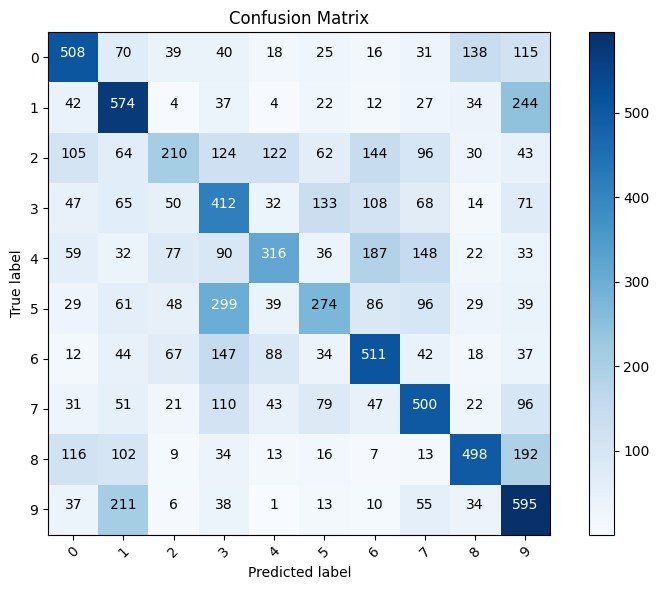

In [ ]:
# correct = 0
# total = 0

# with torch.no_grad():
#   for data in test_loader:
#     images, labels = data
#     images, labels = images.to(device), labels.to(device)

#     outputs = transformer(images)

#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()
#   print(f'\nModel Accuracy: {100 * correct // total} %')



# Testing loop: accumulate predictions and ground truths, then log accuracy and confusion matrix.
transformer.eval()  # Set to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = transformer(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Accumulate predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'\nModel Accuracy: {accuracy:.2f} %')
    wandb.log({"test_accuracy": accuracy})

# Compute confusion matrix using sklearn
cm = confusion_matrix(all_labels, all_preds)


# Plot confusion matrix as a heatmap for logging.
def plot_confusion_matrix(cm, classes,
                          normalize=False,

                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt.gcf()

# Define class names for the confusion matrix (modify as needed)
class_names = [str(i) for i in range(n_classes)]
cm_fig = plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")

# Log the confusion matrix figure with wandb
wandb.log({"confusion_matrix": wandb.Image(cm_fig)})

# Optionally, you can finish the wandb run:
wandb.finish()


#### Visualization

In [ ]:
# import os

# def visualize_attention(model, image, image_idx, save_dir='attention_maps', n_heads=3, n_layers= 2):
#     # Create directory for saving attention maps
#     os.makedirs(save_dir, exist_ok=True)

#     # Set model to evaluation mode
#     model.train(False)

#     # Forward pass to get attention weights
#     _ = model(image)

#     # Get number of patches in each dimension
#     n_patches_h = img_size[0] // patch_size[0]
#     n_patches_w = img_size[1] // patch_size[1]

#     # Original image for reference
#     img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
#     img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize

#     # Visualize attention from the last layer
#     last_layer = model.transformer_encoder[-1]
#     attn_weights = last_layer.mha.attn_weights.cpu().numpy()[0]  # [n_heads, seq_len, seq_len]

#     # Plot attention from [CLS] token to patch tokens for each head in the last layer
#     fig, axes = plt.subplots(1, n_heads, figsize=(15, 10))
#     axes = axes.flatten()

#     for h in range(n_heads):
#         # Get attention weights from [CLS] token (index 0) to all patch tokens
#         cls_attn = attn_weights[h, 0, 1:]  # Skip the [CLS] token itself

#         # Reshape to match the image patches
#         attn_map = cls_attn.reshape(n_patches_h, n_patches_w)
#         # Plot
#         axes[h].imshow(img)
#         im = axes[h].imshow(attn_map, alpha=0.5, cmap='hot')
#         axes[h].set_title(f'Head {h+1}')
#         axes[h].axis('off')

#     # Save the figure with all heads
#     fig.suptitle(f'Attention Maps from [CLS] Token (Last Layer) - Image {image_idx}')
#     fig.tight_layout()
#     fig.savefig(f'{save_dir}/all_heads_last_layer_img{image_idx}.png')

#     # Average attention across all heads
#     avg_attn = attn_weights.mean(axis=0)[0, 1:]
#     avg_attn_map = avg_attn.reshape(n_patches_h, n_patches_w)

#     # Plot average attention
#     fig_avg = plt.figure(figsize=(8, 8))
#     plt.imshow(img)
#     plt.imshow(avg_attn_map, alpha=0.5, cmap='hot')
#     plt.title('Average Attention (Last Layer)')
#     plt.axis('off')
#     plt.savefig(f'{save_dir}/avg_attention_last_layer_img{image_idx}.png')
#     plt.close(fig_avg)

#     # Visualize attention across all layers
#     fig_layers = plt.figure(figsize=(15, 10))

#     for l, encoder in enumerate(model.transformer_encoder):
#         attn_weights = encoder.mha.attn_weights.cpu().numpy()[0]

#         # Average attention across all heads for this layer
#         avg_attn = attn_weights.mean(axis=0)[0, 1:]
#         avg_attn_map = avg_attn.reshape(n_patches_h, n_patches_w)

#         # Plot
#         plt.subplot(1, n_layers, l+1)
#         plt.imshow(img)
#         plt.imshow(avg_attn_map, alpha=0.5, cmap='hot')
#         plt.title(f'Layer {l+1}')
#         plt.axis('off')

#     plt.suptitle(f'Attention Maps Across Layers - Image {image_idx}')
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}/attention_across_layers_img{image_idx}.png')
#     plt.close(fig_layers)

#     # Close the first figure
#     plt.close(fig)

#     # Print statistics about the attention maps for verification
#     print(f"\nAttention statistics for image {image_idx}:")
#     print(f"Last layer attention shape: {attn_weights.shape}")

#     # Print min, max, mean values for each head in the last layer
#     for h in range(n_heads):
#         head_attn = attn_weights[h, 0, 1:]
#         print(f"Head {h+1}: min={head_attn.min():.4f}, max={head_attn.max():.4f}, mean={head_attn.mean():.4f}")

#     # Print average attention statistics
#     print(f"Average attention: min={avg_attn.min():.4f}, max={avg_attn.max():.4f}, mean={avg_attn.mean():.4f}")

#     print(f"Attention maps for image {image_idx} saved to {save_dir}/")

#     # List the saved files
#     saved_files = [
#         f'{save_dir}/all_heads_last_layer_img{image_idx}.png',
#         f'{save_dir}/avg_attention_last_layer_img{image_idx}.png',
#         f'{save_dir}/attention_across_layers_img{image_idx}.png'
#     ]

#     print("Saved files:")
#     for file in saved_files:
#         if os.path.exists(file):
#             print(f"- {file} ({os.path.getsize(file) / 1024:.1f} KB)")
#         else:
#             print(f"- {file} (File not created)")

#     return saved_files



# if __name__ == "__main__":
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     # model = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)
#     for i, data in enumerate(test_loader, 0):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             break
#     visualize_attention(transformer,inputs[0].unsqueeze(0), 1, n_layers = n_layers, n_heads = n_heads)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7719494e37c0>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe


Attention statistics for image 1:
Last layer attention shape: (10, 257, 257)
Head 1: min=0.0033, max=0.0047, mean=0.0039
Head 2: min=0.0018, max=0.0059, mean=0.0039
Head 3: min=0.0025, max=0.0057, mean=0.0039
Head 4: min=0.0032, max=0.0048, mean=0.0039
Head 5: min=0.0028, max=0.0055, mean=0.0039
Head 6: min=0.0023, max=0.0063, mean=0.0039
Head 7: min=0.0033, max=0.0049, mean=0.0039
Head 8: min=0.0028, max=0.0052, mean=0.0039
Head 9: min=0.0028, max=0.0057, mean=0.0039
Head 10: min=0.0017, max=0.0079, mean=0.0039
Average attention: min=0.0034, max=0.0045, mean=0.0039
Attention maps for image 1 saved to attention_maps/
Saved files:
- attention_maps/all_heads_last_layer_img1.png (32.3 KB)
- attention_maps/avg_attention_last_layer_img1.png (11.6 KB)
- attention_maps/attention_across_layers_img1.png (30.5 KB)
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7719494e37c0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

---
---

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend
# import matplotlib.pyplot as plt
# import numpy as np
# from torch.utils.data import DataLoader
# import os

# # Define the components needed for the Vision Transformer
# class PatchEmbedding(nn.Module):
#     def __init__(self, d_model, img_size, patch_size, n_channels):
#         super().__init__()
#         self.d_model = d_model
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.n_channels = n_channels

#         # Linear projection
#         self.proj = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)

#         # Class token
#         self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

#     def forward(self, x):
#         B, C, H, W = x.shape

#         # Project patches
#         x = self.proj(x)  # (B, d_model, H/patch_size, W/patch_size)
#         x = x.flatten(2)  # (B, d_model, n_patches)
#         x = x.transpose(1, 2)  # (B, n_patches, d_model)

#         # Add class token
#         cls_tokens = self.cls_token.expand(B, -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)

#         return x

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super().__init__()
#         self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_length, d_model))

#     def forward(self, x):
#         return x + self.pos_embedding

# class MultiHeadAttention(nn.Module):
#     def __init__(self, d_model, n_heads):
#         super().__init__()
#         self.d_model = d_model
#         self.n_heads = n_heads
#         self.head_dim = d_model // n_heads

#         self.qkv = nn.Linear(d_model, 3 * d_model)
#         self.proj = nn.Linear(d_model, d_model)

#         self.attn_weights = None  # Store attention weights for visualization

#     def forward(self, x):
#         B, N, C = x.shape

#         qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]

#         attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
#         attn = attn.softmax(dim=-1)

#         # Save attention weights for visualization
#         self.attn_weights = attn.detach().clone()

#         x = (attn @ v).transpose(1, 2).reshape(B, N, C)
#         x = self.proj(x)

#         return x

# class TransformerEncoder(nn.Module):
#     def __init__(self, d_model, n_heads):
#         super().__init__()
#         self.attn = MultiHeadAttention(d_model, n_heads)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.mlp = nn.Sequential(
#             nn.Linear(d_model, 4 * d_model),
#             nn.GELU(),
#             nn.Linear(4 * d_model, d_model)
#         )

#     def forward(self, x):
#         x = x + self.attn(self.norm1(x))
#         x = x + self.mlp(self.norm2(x))
#         return x

# class VisionTransformer(nn.Module):
#     def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
#         super().__init__()

#         assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
#         assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

#         self.d_model = d_model # Dimensionality of model
#         self.n_classes = n_classes # Number of classes
#         self.img_size = img_size # Image size
#         self.patch_size = patch_size # Patch size
#         self.n_channels = n_channels # Number of channels
#         self.n_heads = n_heads # Number of attention heads

#         self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
#         self.max_seq_length = self.n_patches + 1

#         self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
#         self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)

#         # Use ModuleList instead of Sequential to access individual layers
#         self.transformer_encoders = nn.ModuleList([TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

#         # Classification MLP
#         self.classifier = nn.Sequential(
#             nn.Linear(self.d_model, self.n_classes),
#             nn.Softmax(dim=-1)
#         )

#     def forward(self, images):
#         x = self.patch_embedding(images)
#         x = self.positional_encoding(x)

#         # Pass through each transformer encoder layer
#         for encoder in self.transformer_encoders:
#             x = encoder(x)

#         # Use the [CLS] token for classification
#         x = self.classifier(x[:,0])

#         return x

# # Function to train a simple ViT model on CIFAR-10
# def train_vit_model(model, epochs=1):
#     # Load CIFAR-10 training dataset
#     transform_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

#     trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=True, transform=transform_train)
#     trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

#     # Define loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#     # Training loop
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
#     model.to(device)

#     for epoch in range(epochs):
#         running_loss = 0.0
#         for i, data in enumerate(trainloader, 0):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             if i % 50 == 49:
#                 print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 50:.3f}')
#                 running_loss = 0.0
#                 # Break early for demonstration purposes
#                 if i >= 99:
#                     break

#     print('Finished Training')
#     return model

# # Function to visualize attention maps
# def visualize_attention(model, image, image_idx, save_dir='attention_maps'):
#     # Create directory for saving attention maps
#     os.makedirs(save_dir, exist_ok=True)

#     # Set model to evaluation mode
#     model.train(False)

#     # Forward pass to get attention weights
#     _ = model(image)

#     # Get number of patches in each dimension
#     n_patches_h = img_size[0] // patch_size[0]
#     n_patches_w = img_size[1] // patch_size[1]

#     # Original image for reference
#     img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
#     img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize

#     # Visualize attention from the last layer
#     last_layer = model.transformer_encoders[-1]
#     attn_weights = last_layer.attn.attn_weights.cpu().numpy()[0]  # [n_heads, seq_len, seq_len]

#     # Plot attention from [CLS] token to patch tokens for each head in the last layer
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#     axes = axes.flatten()

#     for h in range(n_heads):
#         # Get attention weights from [CLS] token (index 0) to all patch tokens
#         cls_attn = attn_weights[h, 0, 1:]  # Skip the [CLS] token itself

#         # Reshape to match the image patches
#         attn_map = cls_attn.reshape(n_patches_h, n_patches_w)
#         # Plot
#         axes[h].imshow(img)
#         im = axes[h].imshow(attn_map, alpha=0.5, cmap='hot')
#         axes[h].set_title(f'Head {h+1}')
#         axes[h].axis('off')

#     # Save the figure with all heads
#     fig.suptitle(f'Attention Maps from [CLS] Token (Last Layer) - Image {image_idx}')
#     fig.tight_layout()
#     fig.savefig(f'{save_dir}/all_heads_last_layer_img{image_idx}.png')

#     # Average attention across all heads
#     avg_attn = attn_weights.mean(axis=0)[0, 1:]
#     avg_attn_map = avg_attn.reshape(n_patches_h, n_patches_w)

#     # Plot average attention
#     fig_avg = plt.figure(figsize=(8, 8))
#     plt.imshow(img)
#     plt.imshow(avg_attn_map, alpha=0.5, cmap='hot')
#     plt.title('Average Attention (Last Layer)')
#     plt.axis('off')
#     plt.savefig(f'{save_dir}/avg_attention_last_layer_img{image_idx}.png')
#     plt.close(fig_avg)

#     # Visualize attention across all layers
#     fig_layers = plt.figure(figsize=(15, 10))

#     for l, encoder in enumerate(model.transformer_encoders):
#         attn_weights = encoder.attn.attn_weights.cpu().numpy()[0]

#         # Average attention across all heads for this layer
#         avg_attn = attn_weights.mean(axis=0)[0, 1:]
#         avg_attn_map = avg_attn.reshape(n_patches_h, n_patches_w)

#         # Plot
#         plt.subplot(2, 3, l+1)
#         plt.imshow(img)
#         plt.imshow(avg_attn_map, alpha=0.5, cmap='hot')
#         plt.title(f'Layer {l+1}')
#         plt.axis('off')

#     plt.suptitle(f'Attention Maps Across Layers - Image {image_idx}')
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}/attention_across_layers_img{image_idx}.png')
#     plt.close(fig_layers)

#     # Close the first figure
#     plt.close(fig)

#     # Print statistics about the attention maps for verification
#     print(f"\nAttention statistics for image {image_idx}:")
#     print(f"Last layer attention shape: {attn_weights.shape}")

#     # Print min, max, mean values for each head in the last layer
#     for h in range(n_heads):
#         head_attn = attn_weights[h, 0, 1:]
#         print(f"Head {h+1}: min={head_attn.min():.4f}, max={head_attn.max():.4f}, mean={head_attn.mean():.4f}")

#     # Print average attention statistics
#     print(f"Average attention: min={avg_attn.min():.4f}, max={avg_attn.max():.4f}, mean={avg_attn.mean():.4f}")

#     print(f"Attention maps for image {image_idx} saved to {save_dir}/")

#     # List the saved files
#     saved_files = [
#         f'{save_dir}/all_heads_last_layer_img{image_idx}.png',
#         f'{save_dir}/avg_attention_last_layer_img{image_idx}.png',
#         f'{save_dir}/attention_across_layers_img{image_idx}.png'
#     ]

#     print("Saved files:")
#     for file in saved_files:
#         if os.path.exists(file):
#             print(f"- {file} ({os.path.getsize(file) / 1024:.1f} KB)")
#         else:
#             print(f"- {file} (File not created)")

#     return saved_files


# if __name__ == "__main__":
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     d_model = 12
#     n_classes = 10
#     img_size = (32,32)
#     patch_size = (2,2)
#     n_channels = 3
#     n_heads = 6
#     n_layers = 6
#     batch_size = 128
#     epochs = 100
#     alpha = 0.005
#     model = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers)
#     train_vit_model(model)
#     for i, data in enumerate(test_loader, 0):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             break
#     visualize_attention(model,inputs[0].unsqueeze(0), 1)


Files already downloaded and verified
Using device: cuda:0
[1, 50] loss: 2.302
[1, 100] loss: 2.270
Finished Training

Attention statistics for image 1:
Last layer attention shape: (6, 257, 257)
Head 1: min=0.0024, max=0.0083, mean=0.0039
Head 2: min=0.0023, max=0.0050, mean=0.0039
Head 3: min=0.0011, max=0.0093, mean=0.0039
Head 4: min=0.0033, max=0.0049, mean=0.0039
Head 5: min=0.0031, max=0.0049, mean=0.0039
Head 6: min=0.0035, max=0.0046, mean=0.0039
Average attention: min=0.0034, max=0.0047, mean=0.0039
Attention maps for image 1 saved to attention_maps/
Saved files:
- attention_maps/all_heads_last_layer_img1.png (28.5 KB)
- attention_maps/avg_attention_last_layer_img1.png (11.5 KB)
- attention_maps/attention_across_layers_img1.png (27.0 KB)


---
---

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend
# import matplotlib.pyplot as plt
# import numpy as np
# from torch.utils.data import DataLoader
# import os
# from skimage.measure import find_contours
# from matplotlib.patches import Polygon
# import cv2
# import colorsys
# import random

# # # Define the components needed for the Vision Transformer
# # class PatchEmbedding(nn.Module):
# #     def __init__(self, d_model, img_size, patch_size, n_channels):
# #         super().__init__()
# #         self.d_model = d_model
# #         self.img_size = img_size
# #         self.patch_size = patch_size
# #         self.n_channels = n_channels

# #         # Linear projection
# #         self.proj = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)

# #         # Class token
# #         self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

# #     def forward(self, x):
# #         B, C, H, W = x.shape

# #         # Project patches
# #         x = self.proj(x)  # (B, d_model, H/patch_size, W/patch_size)
# #         x = x.flatten(2)  # (B, d_model, n_patches)
# #         x = x.transpose(1, 2)  # (B, n_patches, d_model)

# #         # Add class token
# #         cls_tokens = self.cls_token.expand(B, -1, -1)
# #         x = torch.cat((cls_tokens, x), dim=1)

# #         return x

# # class PositionalEncoding(nn.Module):
# #     def __init__(self, d_model, max_seq_length):
# #         super().__init__()
# #         self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_length, d_model))

# #     def forward(self, x):
# #         return x + self.pos_embedding

# # class MultiHeadAttention(nn.Module):
# #     def __init__(self, d_model, n_heads):
# #         super().__init__()
# #         self.d_model = d_model
# #         self.n_heads = n_heads
# #         self.head_dim = d_model // n_heads

# #         self.qkv = nn.Linear(d_model, 3 * d_model)
# #         self.proj = nn.Linear(d_model, d_model)

# #         self.attn_weights = None  # Store attention weights for visualization

# #     def forward(self, x):
# #         B, N, C = x.shape

# #         qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
# #         q, k, v = qkv[0], qkv[1], qkv[2]

# #         attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
# #         attn = attn.softmax(dim=-1)

# #         # Save attention weights for visualization
# #         self.attn_weights = attn.detach().clone()

# #         x = (attn @ v).transpose(1, 2).reshape(B, N, C)
# #         x = self.proj(x)

# #         return x

# # class TransformerEncoder(nn.Module):
# #     def __init__(self, d_model, n_heads):
# #         super().__init__()
# #         self.attn = MultiHeadAttention(d_model, n_heads)
# #         self.norm1 = nn.LayerNorm(d_model)
# #         self.norm2 = nn.LayerNorm(d_model)
# #         self.mlp = nn.Sequential(
# #             nn.Linear(d_model, 4 * d_model),
# #             nn.GELU(),
# #             nn.Linear(4 * d_model, d_model)
# #         )

# #     def forward(self, x):
# #         x = x + self.attn(self.norm1(x))
# #         x = x + self.mlp(self.norm2(x))
# #         return x

# # class VisionTransformer(nn.Module):
# #     def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
# #         super().__init__()

# #         assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
# #         assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

# #         self.d_model = d_model # Dimensionality of model
# #         self.n_classes = n_classes # Number of classes
# #         self.img_size = img_size # Image size
# #         self.patch_size = patch_size # Patch size
# #         self.n_channels = n_channels # Number of channels
# #         self.n_heads = n_heads # Number of attention heads

# #         self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
# #         self.max_seq_length = self.n_patches + 1

# #         self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
# #         self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)

# #         # Use ModuleList instead of Sequential to access individual layers
# #         self.transformer_encoders = nn.ModuleList([TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

# #         # Classification MLP
# #         self.classifier = nn.Sequential(
# #             nn.Linear(self.d_model, self.n_classes),
# #             nn.Softmax(dim=-1)
# #         )

# #     def forward(self, images):
# #         x = self.patch_embedding(images)
# #         x = self.positional_encoding(x)

# #         # Pass through each transformer encoder layer
# #         for encoder in self.transformer_encoders:
# #             x = encoder(x)

# #         # Use the [CLS] token for classification
# #         x = self.classifier(x[:,0])

# #         return x


# #########################################
# # Define the components needed for the Vision Transformer
# class PatchEmbedding(nn.Module):
#     def __init__(self, d_model, img_size, patch_size, n_channels):
#         super().__init__()
#         self.d_model = d_model
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.n_channels = n_channels

#         # Linear projection
#         self.proj = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)

#         # Class token
#         self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

#     def forward(self, x):
#         B, C, H, W = x.shape

#         # Project patches
#         x = self.proj(x)  # (B, d_model, H/patch_size, W/patch_size)
#         x = x.flatten(2)  # (B, d_model, n_patches)
#         x = x.transpose(1, 2)  # (B, n_patches, d_model)

#         # Add class token
#         cls_tokens = self.cls_token.expand(B, -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)

#         return x

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super().__init__()
#         self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_length, d_model))

#     def forward(self, x):
#         return x + self.pos_embedding

# class MultiHeadAttention(nn.Module):
#     def __init__(self, d_model, n_heads):
#         super().__init__()
#         self.d_model = d_model
#         self.n_heads = n_heads
#         self.head_dim = d_model // n_heads

#         self.qkv = nn.Linear(d_model, 3 * d_model)
#         self.proj = nn.Linear(d_model, d_model)

#         self.attn_weights = None  # Store attention weights for visualization

#     def forward(self, x):
#         B, N, C = x.shape

#         qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]

#         attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
#         attn = attn.softmax(dim=-1)

#         # Save attention weights for visualization
#         self.attn_weights = attn.detach().clone()

#         x = (attn @ v).transpose(1, 2).reshape(B, N, C)
#         x = self.proj(x)

#         return x

# class TransformerEncoder(nn.Module):
#     def __init__(self, d_model, n_heads):
#         super().__init__()
#         self.attn = MultiHeadAttention(d_model, n_heads)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.mlp = nn.Sequential(
#             nn.Linear(d_model, 4 * d_model),
#             nn.GELU(),
#             nn.Linear(4 * d_model, d_model)
#         )

#     def forward(self, x):
#         x = x + self.attn(self.norm1(x))
#         x = x + self.mlp(self.norm2(x))
#         return x

# class VisionTransformer(nn.Module):
#     def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
#         super().__init__()

#         assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
#         assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

#         self.d_model = d_model # Dimensionality of model
#         self.n_classes = n_classes # Number of classes
#         self.img_size = img_size # Image size
#         self.patch_size = patch_size # Patch size
#         self.n_channels = n_channels # Number of channels
#         self.n_heads = n_heads # Number of attention heads

#         self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
#         self.max_seq_length = self.n_patches + 1

#         self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
#         self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)

#         # Use ModuleList instead of Sequential to access individual layers
#         self.transformer_encoders = nn.ModuleList([TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

#         # Classification MLP
#         self.classifier = nn.Sequential(
#             nn.Linear(self.d_model, self.n_classes),
#             nn.Softmax(dim=-1)
#         )

#     def forward(self, images):
#         x = self.patch_embedding(images)
#         x = self.positional_encoding(x)

#         # Pass through each transformer encoder layer
#         for encoder in self.transformer_encoders:
#             x = encoder(x)

#         # Use the [CLS] token for classification
#         x = self.classifier(x[:,0])

#         return x

#     def get_last_selfattention(self, x):
#         x = self.patch_embedding(x)
#         x = self.positional_encoding(x)

#         # Pass through each transformer encoder layer except the last one
#         for i, encoder in enumerate(self.transformer_encoders[:-1]):
#             x = encoder(x)

#         # For the last layer, we need to get the attention weights
#         last_encoder = self.transformer_encoders[-1]
#         x = last_encoder.norm1(x)

#         # Extract QKV
#         B, N, C = x.shape
#         qkv = last_encoder.attn.qkv(x).reshape(B, N, 3, last_encoder.attn.n_heads, last_encoder.attn.head_dim).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]

#         # Calculate attention
#         attn = (q @ k.transpose(-2, -1)) * (last_encoder.attn.head_dim ** -0.5)
#         attn = attn.softmax(dim=-1)

#         return attn

# # Function to train a simple ViT model on CIFAR-10
# def train_vit_model(model, epochs=1):
#     # Load CIFAR-10 training dataset
#     transform_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

#     trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=True, transform=transform_train)
#     trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

#     # Define loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#     # Training loop
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
#     model.to(device)

#     for epoch in range(epochs):
#         running_loss = 0.0
#         for i, data in enumerate(trainloader, 0):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             if i % 50 == 49:
#                 print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 50:.3f}')
#                 running_loss = 0.0
#                 # Break early for demonstration purposes
#                 if i >= 99:
#                     break

#     print('Finished Training')
#     return model

# # Function to visualize attention maps
# # def visualize_attention(model, image, image_idx, save_dir='attention_maps'):
# #     # Create directory for saving attention maps
# #     os.makedirs(save_dir, exist_ok=True)

# #     # Set model to evaluation mode
# #     model.train(False)

# #     # Forward pass to get attention weights
# #     _ = model(image)

# #     # Get number of patches in each dimension
# #     n_patches_h = img_size[0] // patch_size[0]
# #     n_patches_w = img_size[1] // patch_size[1]

# #     # Original image for reference
# #     img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
# #     img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize

# #     # Visualize attention from the last layer
# #     last_layer = model.transformer_encoders[-1]
# #     attn_weights = last_layer.attn.attn_weights.cpu().numpy()[0]  # [n_heads, seq_len, seq_len]

# #     # Plot attention from [CLS] token to patch tokens for each head in the last layer
# #     fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# #     axes = axes.flatten()

# #     for h in range(n_heads):
# #         # Get attention weights from [CLS] token (index 0) to all patch tokens
# #         cls_attn = attn_weights[h, 0, 1:]  # Skip the [CLS] token itself

# #         # Reshape to match the image patches
# #         attn_map = cls_attn.reshape(n_patches_h, n_patches_w)
# #         # Plot
# #         axes[h].imshow(img)
# #         im = axes[h].imshow(attn_map, alpha=0.5, cmap='hot')
# #         axes[h].set_title(f'Head {h+1}')
# #         axes[h].axis('off')

# #     # Save the figure with all heads
# #     fig.suptitle(f'Attention Maps from [CLS] Token (Last Layer) - Image {image_idx}')
# #     fig.tight_layout()
# #     fig.savefig(f'{save_dir}/all_heads_last_layer_img{image_idx}.png')

# #     # Average attention across all heads
# #     avg_attn = attn_weights.mean(axis=0)[0, 1:]
# #     avg_attn_map = avg_attn.reshape(n_patches_h, n_patches_w)

# #     # Plot average attention
# #     fig_avg = plt.figure(figsize=(8, 8))
# #     plt.imshow(img)
# #     plt.imshow(avg_attn_map, alpha=0.5, cmap='hot')
# #     plt.title('Average Attention (Last Layer)')
# #     plt.axis('off')
# #     plt.savefig(f'{save_dir}/avg_attention_last_layer_img{image_idx}.png')
# #     plt.close(fig_avg)

# #     # Visualize attention across all layers
# #     fig_layers = plt.figure(figsize=(15, 10))

# #     for l, encoder in enumerate(model.transformer_encoders):
# #         attn_weights = encoder.attn.attn_weights.cpu().numpy()[0]

# #         # Average attention across all heads for this layer
# #         avg_attn = attn_weights.mean(axis=0)[0, 1:]
# #         avg_attn_map = avg_attn.reshape(n_patches_h, n_patches_w)

# #         # Plot
# #         plt.subplot(2, 3, l+1)
# #         plt.imshow(img)
# #         plt.imshow(avg_attn_map, alpha=0.5, cmap='hot')
# #         plt.title(f'Layer {l+1}')
# #         plt.axis('off')

# #     plt.suptitle(f'Attention Maps Across Layers - Image {image_idx}')
# #     plt.tight_layout()
# #     plt.savefig(f'{save_dir}/attention_across_layers_img{image_idx}.png')
# #     plt.close(fig_layers)

# #     # Close the first figure
# #     plt.close(fig)

# #     # Print statistics about the attention maps for verification
# #     print(f"\nAttention statistics for image {image_idx}:")
# #     print(f"Last layer attention shape: {attn_weights.shape}")

# #     # Print min, max, mean values for each head in the last layer
# #     for h in range(n_heads):
# #         head_attn = attn_weights[h, 0, 1:]
# #         print(f"Head {h+1}: min={head_attn.min():.4f}, max={head_attn.max():.4f}, mean={head_attn.mean():.4f}")

# #     # Print average attention statistics
# #     print(f"Average attention: min={avg_attn.min():.4f}, max={avg_attn.max():.4f}, mean={avg_attn.mean():.4f}")

# #     print(f"Attention maps for image {image_idx} saved to {save_dir}/")

# #     # List the saved files
# #     saved_files = [
# #         f'{save_dir}/all_heads_last_layer_img{image_idx}.png',
# #         f'{save_dir}/avg_attention_last_layer_img{image_idx}.png',
# #         f'{save_dir}/attention_across_layers_img{image_idx}.png'
# #     ]

# #     print("Saved files:")
# #     for file in saved_files:
# #         if os.path.exists(file):
# #             print(f"- {file} ({os.path.getsize(file) / 1024:.1f} KB)")
# #         else:
# #             print(f"- {file} (File not created)")

# #     return saved_files

# #######################
# # Helper functions for visualization
# def apply_mask(image, mask, color, alpha=0.5):
#     """Apply mask to image with specified color and transparency."""
#     for c in range(3):
#         image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
#     return image

# def random_colors(N, bright=True):
#     """Generate random colors."""
#     brightness = 1.0 if bright else 0.7
#     hsv = [(i / N, 1, brightness) for i in range(N)]
#     colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
#     random.shuffle(colors)
#     return colors

# def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
#     """Display segmentation masks on an image."""
#     fig = plt.figure(figsize=figsize, frameon=False)
#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)
#     ax = plt.gca()

#     N = 1
#     mask = mask[None, :, :]
#     # Generate random colors
#     colors = random_colors(N)

#     # Show area outside image boundaries.
#     height, width = image.shape[:2]
#     margin = 0
#     ax.set_ylim(height + margin, -margin)
#     ax.set_xlim(-margin, width + margin)
#     ax.axis('off')
#     masked_image = image.astype(np.uint32).copy()
#     for i in range(N):
#         color = colors[i]
#         _mask = mask[i]
#         if blur:
#             _mask = cv2.blur(_mask, (10, 10))
#         # Mask
#         masked_image = apply_mask(masked_image, _mask, color, alpha)
#         # Mask Polygon
#         # Pad to ensure proper polygons for masks that touch image edges.
#         if contour:
#             padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
#             padded_mask[1:-1, 1:-1] = _mask
#             contours = find_contours(padded_mask, 0.5)
#             for verts in contours:
#                 # Subtract the padding and flip (y, x) to (x, y)
#                 verts = np.fliplr(verts) - 1
#                 p = Polygon(verts, facecolor="none", edgecolor=color)
#                 ax.add_patch(p)
#     ax.imshow(masked_image.astype(np.uint8), aspect='auto')
#     fig.savefig(fname)
#     plt.close(fig)
#     print(f"{fname} saved.")
#     return

# def visualize_attention_improved(model, image, image_idx, threshold=0.6, save_dir='attention_maps_improved'):
#     """
#     Visualize attention maps with improved visualization techniques.

#     Args:
#         model: The Vision Transformer model
#         image: Input image tensor
#         image_idx: Image index for saving files
#         threshold: Threshold for attention mask (keep top % of attention mass)
#         save_dir: Directory to save visualizations
#     """
#     # Create directory for saving attention maps
#     os.makedirs(save_dir, exist_ok=True)

#     # Set model to evaluation mode
#     model.train(False)

#     # Get attention weights from the last layer
#     # last_layer = model.transformer_encoders[-1]
#     # attentions = last_layer.attn.attn_weights.cpu().numpy()[0]  # [n_heads, seq_len, seq_len]

#     attentions = model.get_last_selfattention(image)

#     # Convert image for visualization
#     img_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
#     img_np = (img_np * 0.5 + 0.5).clip(0, 1)  # Denormalize
#     img_uint8 = (img_np * 255).astype(np.uint8)

#     # Save the original image
#     plt.figure(figsize=(5, 5))
#     plt.imshow(img_np)
#     plt.axis('off')
#     plt.savefig(f'{save_dir}/original_img{image_idx}.png')
#     plt.close()

#     # Get dimensions
#     n_heads = attentions.shape[1]
#     h_featmap = img_np.shape[0] // model.patch_size[0]
#     w_featmap = img_np.shape[1] // model.patch_size[1]

#     # Process attention weights
#     attentions = attentions[0]  # First batch
#     print(">>>>>>>", attentions.shape)
#     # We focus on attention from CLS token to patch tokens
#     cls_attn = attentions[:, 0, 1:].reshape(n_heads, -1)

#     # Apply thresholding to keep only a certain percentage of the mass
#     if threshold is not None:
#         # Sort attention values
#         val, idx = torch.sort(cls_attn, dim=1)
#         val /= torch.sum(val, dim=1, keepdim=True)
#         cumval = torch.cumsum(val, dim=1)
#         th_attn = cumval > (1 - threshold)

#         # Reorder to original order
#         idx2 = torch.argsort(idx)
#         for head in range(n_heads):
#             th_attn[head] = th_attn[head][idx2[head]]

#         # Reshape to feature map dimensions
#         th_attn = th_attn.reshape(n_heads, h_featmap, w_featmap).float()

#         # Interpolate to image size
#         th_attn = nn.functional.interpolate(
#             th_attn.unsqueeze(0), 
#             scale_factor=model.patch_size[0], 
#             mode="nearest"
#         )[0].cpu().numpy()

#     # Reshape and interpolate attention maps to image size
#     cls_attn = cls_attn.reshape(n_heads, h_featmap, w_featmap)
#     cls_attn = nn.functional.interpolate(
#         cls_attn.unsqueeze(0), 
#         scale_factor=model.patch_size[0], 
#         mode="nearest"
#     )[0].detach().cpu().numpy()

#     # Save raw attention heatmaps
#     for j in range(n_heads):
#         fname = f'{save_dir}/attn_heatmap_head{j}_img{image_idx}.png'
#         plt.figure(figsize=(5, 5))
#         plt.imshow(cls_attn[j])
#         plt.axis('off')
#         plt.colorbar()
#         plt.savefig(fname)
#         plt.close()
#         print(f"{fname} saved.")

#     # Save attention masks with contours
#     if threshold is not None:
#         for j in range(n_heads):
#             fname = f'{save_dir}/attn_mask_th{threshold}_head{j}_img{image_idx}.png'
#             display_instances(
#                 img_uint8, 
#                 th_attn[j], 
#                 fname=fname, 
#                 blur=False, 
#                 contour=True, 
#                 alpha=0.5
#             )

#     # Create a grid of all attention heads
#     fig, axes = plt.subplots(2, n_heads//2, figsize=(15, 8))
#     axes = axes.flatten()

#     for j in range(n_heads):
#         axes[j].imshow(img_np)



# if __name__ == "__main__":
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     d_model = 12
#     n_classes = 10
#     img_size = (32,32)
#     patch_size = (2,2)
#     n_channels = 3
#     n_heads = 6
#     n_layers = 6
#     batch_size = 128
#     epochs = 100
#     alpha = 0.005
#     model = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers)
#     train_vit_model(model)
#     for i, data in enumerate(test_loader, 0):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             break
#     visualize_attention_improved(model,inputs[0].unsqueeze(0), 1)
